In [1]:
!date

Thu Nov 19 15:01:42 PST 2020


# Sex gene subclass DE 

In [1]:
!mkdir plots tables

mkdir: cannot create directory ‘plots’: File exists
mkdir: cannot create directory ‘tables’: File exists


In [2]:
import sys

colab = "google.colab" in sys.modules

if colab:
    # download files
    !git clone https://github.com/pachterlab/BYVSTZP_2020.git
    !wget -q --show-progress --progress=bar:force -O gene.h5ad.gz https://caltech.box.com/shared/static/2qut50hmb5r2zynd0dkihlj0qpwi6576.gz 2>&1
    !wget -q --show-progress --progress=bar:force -O 10x_l5it_sex.csv.gz https://caltech.box.com/shared/static/4xj7f2ty7ganvli8dxv08cqb1nacgxi5.gz 2>&1
    !gunzip *.gz

    !pip install --quiet anndata UpSetPlot

In [1]:
import anndata
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

def nd(arr):
    return np.asarray(arr).reshape(-1)


fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
gene = anndata.read_h5ad("gene.h5ad")

In [3]:
md = pd.read_csv("BYVSTZP_2020/reference/smartseq/sample_metadata.csv", index_col = 0)

gene.obs["sex"] = gene.obs.cell_id.map(md["gender"])

In [4]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("BYVSTZP_2020/reference/kallisto_index/t2g.txt", sep="\t", header=None, names=cols)
t2g.index = t2g.transcript_id.apply(lambda x: x.split(".")[0]).values

In [5]:
t2g.index = t2g.gene_name +"_"+ t2g.gene_id.apply(lambda x: "".join(x.split(".")[:-1]))

16-Jul-21 14:18:47 - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
16-Jul-21 14:18:47 - NumExpr defaulting to 8 threads.


In [6]:
t2g = t2g[~t2g.index.duplicated(keep='first')]

In [7]:
gene.var["chromosome"] = gene.var.gene_name.map(t2g["chromosome"]).values

In [8]:
gene.obs.head()

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,cell_id,subclass_id,class_id,cell_counts,percent_mito,n_genes,pass_count_filter,leiden,louvain,sex
0,10,Vip Chat_1,Vip,GABAergic,#FF00FF,33,LS-15395_S47_E1-50,17,0,1407.604370,5.133205,8359,True,5,6,F
1,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S48_E1-50,3,1,1364.093994,3.866734,12414,True,9,8,F
2,4,Lamp5 Slc35d3,Lamp5,GABAergic,#FFA388,194,LS-15395_S49_E1-50,10,0,1312.558105,3.064962,10739,True,8,9,F
3,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S50_E1-50,3,1,1474.197754,5.937931,12751,True,9,8,F
4,20,Sst Myh8_2,Sst,GABAergic,#D27A2A,55,LS-15395_S51_E1-50,15,0,1372.883789,2.231945,9674,True,7,7,F


In [9]:
gene = gene[~gene.obs.eval("subclass_label == 'Low Quality'").values]

In [10]:
clusters = np.unique(gene.obs.subclass_label.values)

In [11]:
clusters

array(['Astro', 'Endo', 'L2/3 IT', 'L5 IT', 'L5 PT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Pvalb', 'SMC', 'Sncg',
       'Sst', 'VLMC', 'Vip'], dtype=object)

In [12]:
gene.obs.sex.value_counts()

M    4199
F    1949
Name: sex, dtype: int64

In [13]:
%%time
de_clusters = []
de_genes = []
for cidx, c in enumerate(clusters):
    print(f"{cidx+1} of {len(clusters)}: {c}")
    tmp_gene = gene[gene.obs.eval(f"subclass_label == '{c}'")].copy()
    if tmp_gene.obs.sex.nunique() > 1:

        ######### Isoforms
        mat           = tmp_gene.layers["log1p"].todense()
        components    = tmp_gene.obs.cell_id.values
        features      = tmp_gene.var.gene_name.values
        assignments   = tmp_gene.obs.sex.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in cluster
        corr_method   = "bonferroni"


        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_raw = p_raw/2
        p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

        s = stat

        markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

        # convert the 0 pvalues to the smallest possible float
        markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
        markers_gene = markers_gene.query("es>0")
        markers_gene["cluster"] = c
        de_genes.append(markers_gene)

16-Jul-21 14:19:01 - 1 of 2 assignments: F
16-Jul-21 14:19:01 - 2 of 2 assignments: M
16-Jul-21 14:19:01 - 1 of 2 assignments: F
16-Jul-21 14:19:01 - 2 of 2 assignments: M


1 of 17: Astro
2 of 17: Endo
3 of 17: L2/3 IT


16-Jul-21 14:19:02 - 1 of 2 assignments: F
16-Jul-21 14:19:02 - 2 of 2 assignments: M


4 of 17: L5 IT


16-Jul-21 14:19:03 - 1 of 2 assignments: F
16-Jul-21 14:19:03 - 2 of 2 assignments: M
16-Jul-21 14:19:03 - 1 of 2 assignments: F
16-Jul-21 14:19:03 - 2 of 2 assignments: M
16-Jul-21 14:19:03 - 1 of 2 assignments: F


5 of 17: L5 PT
6 of 17: L5/6 NP


16-Jul-21 14:19:03 - 2 of 2 assignments: M


7 of 17: L6 CT


16-Jul-21 14:19:04 - 1 of 2 assignments: F
16-Jul-21 14:19:04 - 2 of 2 assignments: M
16-Jul-21 14:19:04 - 1 of 2 assignments: F


8 of 17: L6 IT


16-Jul-21 14:19:05 - 2 of 2 assignments: M
16-Jul-21 14:19:05 - 1 of 2 assignments: F
16-Jul-21 14:19:05 - 2 of 2 assignments: M


9 of 17: L6 IT Car3
10 of 17: L6b


16-Jul-21 14:19:05 - 1 of 2 assignments: F
16-Jul-21 14:19:05 - 2 of 2 assignments: M
16-Jul-21 14:19:05 - 1 of 2 assignments: F
16-Jul-21 14:19:05 - 2 of 2 assignments: M


11 of 17: Lamp5
12 of 17: Pvalb


16-Jul-21 14:19:06 - 1 of 2 assignments: F
16-Jul-21 14:19:06 - 2 of 2 assignments: M
16-Jul-21 14:19:06 - 1 of 2 assignments: F
16-Jul-21 14:19:06 - 2 of 2 assignments: M
16-Jul-21 14:19:06 - 1 of 2 assignments: F
16-Jul-21 14:19:06 - 2 of 2 assignments: M


13 of 17: SMC
14 of 17: Sncg
15 of 17: Sst


16-Jul-21 14:19:06 - 1 of 2 assignments: F
16-Jul-21 14:19:06 - 2 of 2 assignments: M
16-Jul-21 14:19:06 - 1 of 2 assignments: F
16-Jul-21 14:19:06 - 2 of 2 assignments: M


16 of 17: VLMC
17 of 17: Vip


16-Jul-21 14:19:07 - 1 of 2 assignments: F
16-Jul-21 14:19:07 - 2 of 2 assignments: M


CPU times: user 3.59 s, sys: 1.85 s, total: 5.45 s
Wall time: 5.41 s


In [14]:
markers_gene = pd.concat(de_genes)

In [15]:
markers_gene["n_cells"] = markers_gene.cluster.map(gene.obs.subclass_label.value_counts())

In [16]:
alpha = 0.01
markers_gene = markers_gene.query(f"p_corr < {alpha}")

In [17]:
markers_gene["chromosome"] = markers_gene.name.map(t2g["chromosome"])

In [18]:
markers_gene = markers_gene.sort_values(["es"]).query("chromosome != 'X' & chromosome != 'Y'")

# Upset plot

In [19]:
from upsetplot import from_contents
import upsetplot

In [20]:
markers_gene

,index,name,p_raw,p_corr,es,cluster,n_cells,chromosome
32089,M,Ppia_ENSMUSG00000071866,0.000001,0.002079,0.073357,Pvalb,521,NaN
34862,M,Calm1_ENSMUSG00000001175,0.000000,0.000001,0.074010,L6 CT,904,NaN
31634,M,Morf4l1_ENSMUSG00000062270,0.000002,0.009032,0.074725,L5 IT,1561,NaN
29027,M,Naca_ENSMUSG00000061315,0.000001,0.005985,0.075169,L5 IT,1561,NaN
19545,M,Rpl37a_ENSMUSG00000046330,0.000001,0.003037,0.080564,L5 IT,1561,NaN
...,...,...,...,...,...,...,...,...
2587,F,Psma7_ENSMUSG00000027566,0.000001,0.001150,5.844351,VLMC,6,NaN
18023,F,Cox7a2l_ENSMUSG00000024248,0.000000,0.000703,5.858546,VLMC,6,NaN
1254,F,Arrdc1_ENSMUSG00000026972,0.000000,0.001787,5.896260,Endo,7,NaN
8650,F,Sult1a1_ENSMUSG00000030711,0.000000,0.000891,5.926821,Endo,7,NaN


In [21]:
# Males & females
contents = markers_gene.groupby("cluster")["name"].apply(list).to_dict()

data = from_contents(contents)

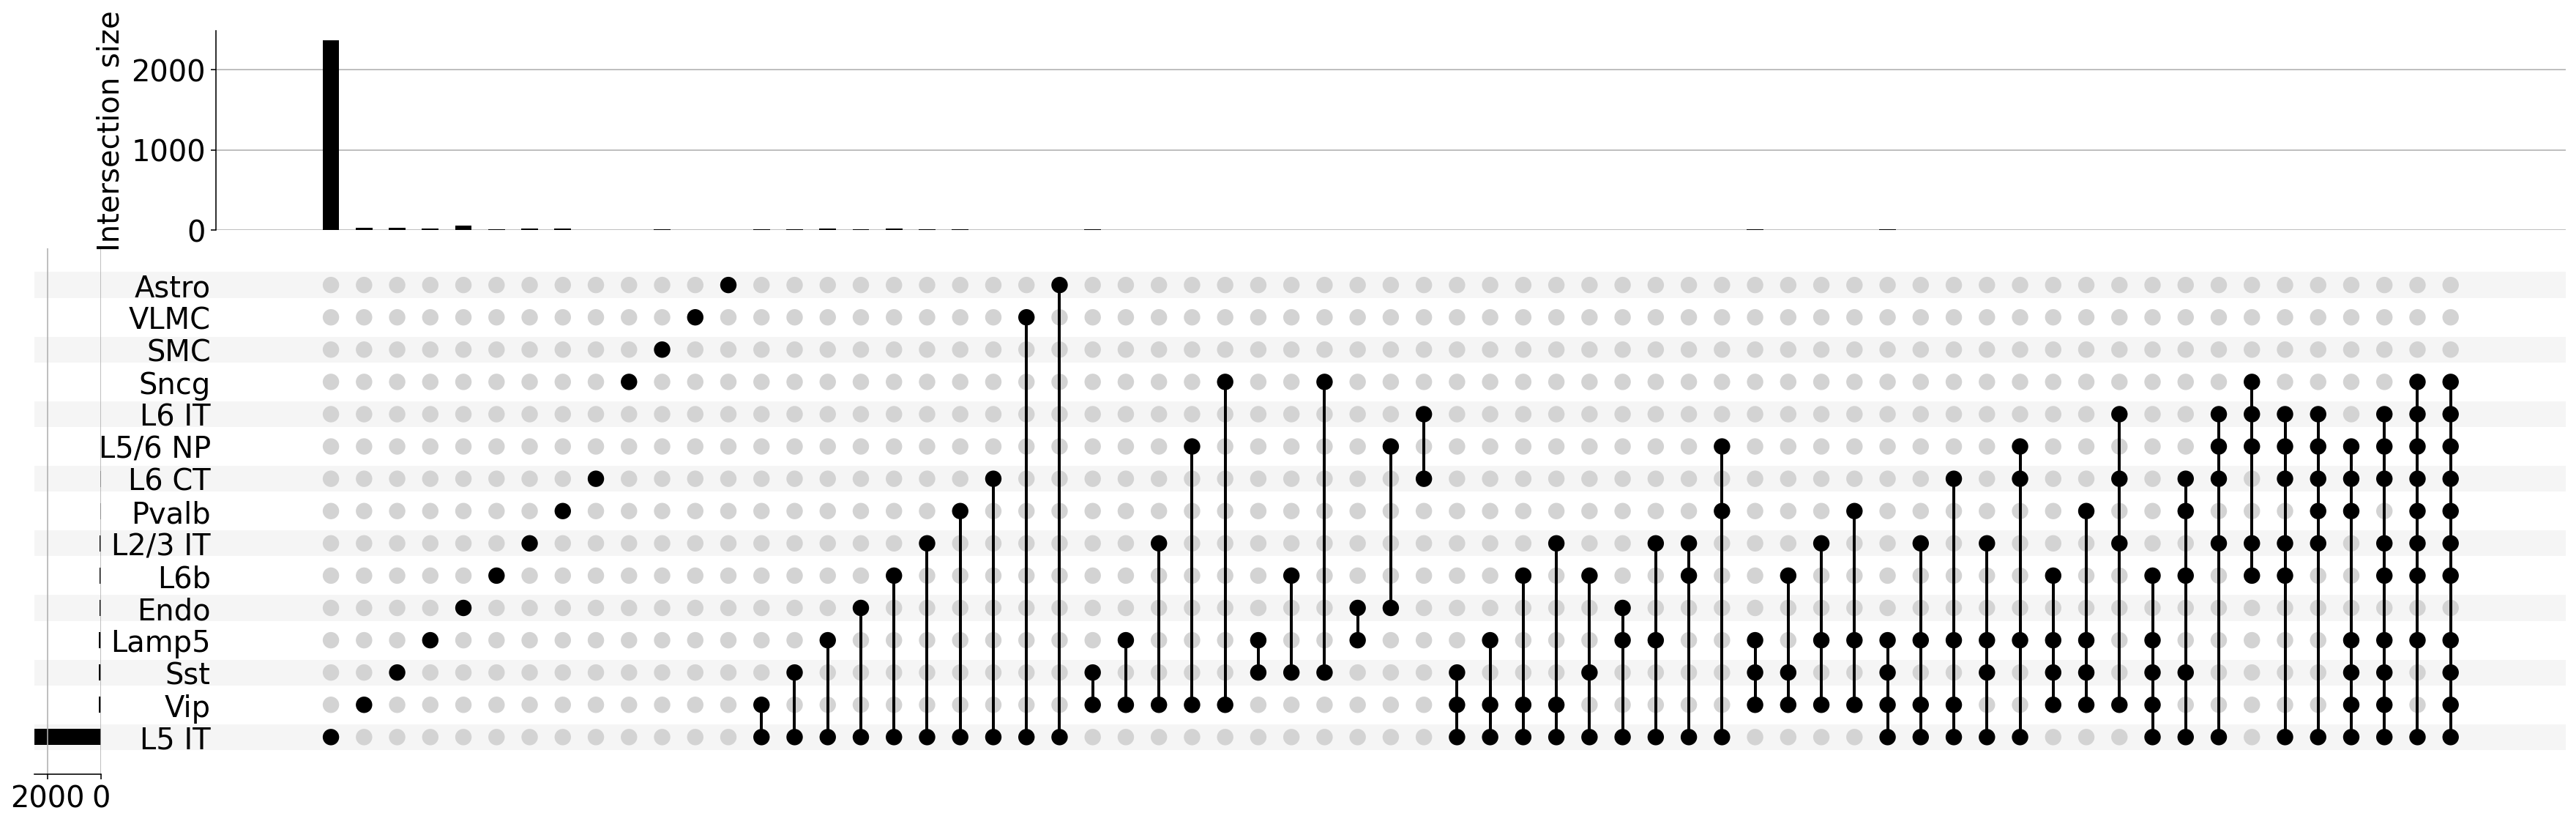

In [22]:
fig = plt.figure()
ax = upsetplot.plot(data, fig=fig)

#fig.savefig("./plots/smartseq_gene_upset_sex.png", bbox_inches='tight', dpi=300)

fig.show()

In [23]:
markers_gene["es"] = markers_gene.es.values.astype(float)
markers_gene["p_corr"] = markers_gene.p_corr.values.astype(float)

In [24]:
fmg = markers_gene[markers_gene.n_cells>0.05*gene.shape[0]]

In [219]:
# keep = (markers_gene.query("index=='F'").cluster.value_counts()>15)

# keep = keep[keep.values].index

# new = markers_gene.query("index=='F'")[markers_gene.query("index=='F'").cluster.isin(keep)]

# idx = new.groupby("cluster")["p_corr"].nsmallest(10).reset_index(level=0, drop=True).index

# new.loc[idx].groupby("cluster")["es"].mean().sort_values()

In [25]:
keep = (fmg.cluster.value_counts()>50)

keep = keep[keep.values].index

new = fmg[fmg.cluster.isin(keep)]

idx = new.groupby("cluster")["p_corr"].nsmallest(10).reset_index(level=0, drop=True).index

new.loc[idx].groupby("cluster")["es"].mean().sort_values()

cluster
Sst      1.345019
Vip      1.357541
Lamp5    1.483830
L5 IT    2.046333
Name: es, dtype: float64

In [26]:
np.arange(markers_gene.query("cluster == 'L5 IT' and index=='M'").shape[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [27]:
markers_gene[markers_gene.name.str.contains("Shank")]

,index,name,p_raw,p_corr,es,cluster,n_cells,chromosome
27158,M,Shank1_ENSMUSG00000038738,0.0,7.545638e-13,0.176217,L5 IT,1561,NaN
27158,M,Shank1_ENSMUSG00000038738,0.0,1.906729e-05,0.321458,Vip,607,NaN


In [28]:
d = {
    "name": markers_gene.query("cluster == 'L5 IT' and index=='M'").sort_values("p_corr").name.values,
    "rank": np.arange(markers_gene.query("cluster == 'L5 IT' and index=='M'").shape[0])
}
ss = pd.DataFrame(d)

In [29]:
ss

,name,rank
0,Eif2s3y_ENSMUSG00000069049,0
1,Kdm5d_ENSMUSG00000056673,1
2,Uty_ENSMUSG00000068457,2
3,Tatdn1_ENSMUSG00000050891,3
4,Bc1_ENSMUSG00000115783,4
...,...,...
249,Krt10_ENSMUSG00000019761,249
250,2010107E04Rik_ENSMUSG00000021290,250
251,Jpt1_ENSMUSG00000020737,251
252,Nrsn1_ENSMUSG00000048978,252


In [30]:
# ss.to_csv("../../data/notebook/revision/ss_l5it_sex.csv")
ss.to_csv("./tables/ss_l5it_sex.csv")

In [31]:
tx = pd.read_csv("10x_l5it_sex.csv")

# Venn diagram of genes

In [32]:
import numpy as np
from matplotlib_venn import venn3, venn2

def venn_diagram(a, b, labels=['A', 'B']):
    
    a = list(set(a))
    b = list(set(b))
    
    
    only_a = len( [x for x in a if x not in b] )
    only_b = len( [x for x in b if x not in a] )

    a_b = len(np.intersect1d(a, b))
    
    
    venn2(subsets=(only_a, only_b, a_b), set_labels=labels)    

#

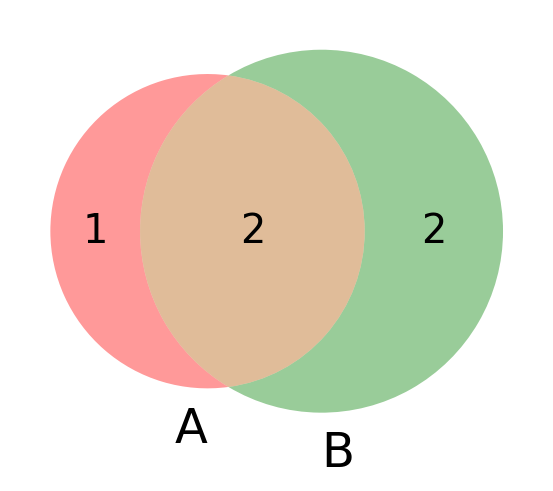

In [33]:
venn_diagram([1, 2, 5], [1, 2, 3, 4])

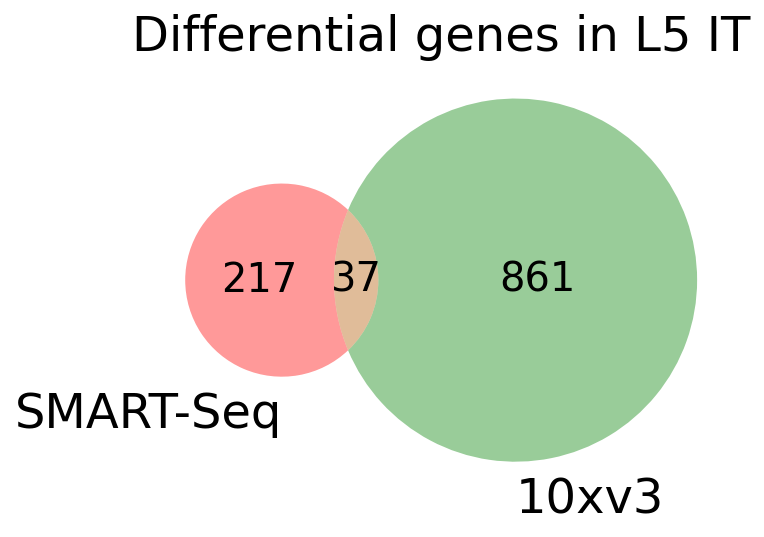

In [34]:
venn_diagram(ss.name.values.tolist(), tx.name.values.tolist(), labels=["SMART-Seq", "10xv3"])
plt.title("Differential genes in L5 IT") 
plt.savefig("./plots/l5it_ss_tx_genes_venn.png", bbox_inches="tight", dpi=300)
plt.show()